In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import ipyleaflet

from ipyleaflet import (Map, GeoData, basemaps, WidgetControl, GeoJSON, LayersControl, Icon, Marker,basemap_to_tiles, Choropleth,MarkerCluster, Heatmap, SearchControl, FullScreenControl)

from ipywidgets import (HTML, IntSlider, jslink)

import json

import seaborn as sns
import matplotlib.pyplot as plt
import bokeh

# Elevation benchmark map for Aalborg Municipality

## Reading and preparing the data

I have loaded the benchmark WFS layer (https://datafordeler.dk/dataoversigt/danmarks-fikspunktsregister/fikspunkter-simpel-struktur/) into QGIS and exported all elevation benchmarks in Aalborg municipality to a shapefile. The shapefile is loaded and it contains point geometries with an elevation ("kote"):

In [2]:
benchmark = gpd.read_file('hoejdefikspunkter_AA.shp')
benchmark.head()

HTTPError: HTTP Error 403: Forbidden

Changing the coordinates to lat/lon so it will work in ipyleaflet:

In [3]:
benchmark = benchmark.to_crs({'init': 'epsg:4326'})

C:\Users\tester\anaconda3\envs\ppa\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## Creating the map

Creating the base map:

In [112]:
map = Map(center=(57.0,10.0), zoom = 7, basemap= basemaps.Esri.WorldTopoMap)

Next I create markers for the benchmark locations. Since I want to use the MarkerCluster function, which needs the markers to be listed, I first create an empty list to contain the markers. Then I can create a loop that appends each marker to the list. The loop grabs the i'th benchmarks location and assigns its elevation to a string that can be displayed as the marker popup.

The cell below reguires a bit of computing since Aalborg Municipality contains 2554 benchmarks. For a quicker computation the range can be modified from "range(len(benchmark))" to e.g. "range(0,200)" to only contain the first 200 benchmarks.

In [108]:
li = [] # empty list

for i in range(len(benchmark)):
    location = (benchmark.geometry.y[i],benchmark.geometry.x[i])
    elevation = f'Elevation: {benchmark.kote[i]}m'

    marker = Marker(location=location)
    marker.popup = HTML(elevation)
    li.append(marker) # appends the i'th marker to the list

Next i can add a MarkerCluster layer to the map with all markers contained in the list from the previous step. I add a zoom slider as well.

In [113]:
map.add_layer(MarkerCluster(
 markers=li)
 )

zoom_slider = IntSlider(description='Zoom level:', min=0, max=17, value=7)
jslink((zoom_slider, 'value'), (map, 'zoom'))
widget_control1 = WidgetControl(widget=zoom_slider, position='topright')
map.add_control(widget_control1)

In [114]:
map

Map(center=[57.0, 10.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

Instead of displaying a lot of overlapping markers, which can look very messy, the map displays how many bencmarks are in a given area. When zooming in this is split into smaller areas until you reach a zoom level where the markers can be displayed resonably.

Zooming can be performed by using the slider or by clicking on a "bubble". When clicking on a marker its elevation is displayed in a popup.

## Seaborn

First i assign each coordinate of the benchmarks to its own variable:

In [49]:
x = benchmark.geometry.x
y = benchmark.geometry.y
z = benchmark['kote']

Then i can plot the elevations along the longtitude, together with a regression line, to se if there is any overall trend. Of course benchmarks are placed at various distances from the ground, but it can still give an idea off whether some part of the municipality is at a different elevation. 

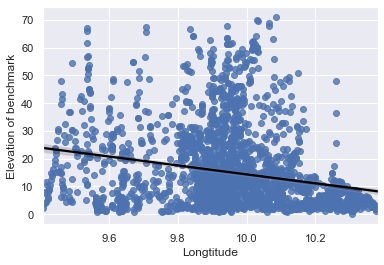

In [95]:
p1 = sns.regplot(x=x, y=z, line_kws = {'color': 'black'})
p1.set(xlabel='Longtitude', ylabel='Elevation of benchmark');

The plot shows that the eastern part of the municipality is generally at a lower elevation.

A similar plot is created along the latitude. This shows how the northern part is at a lower elevation.

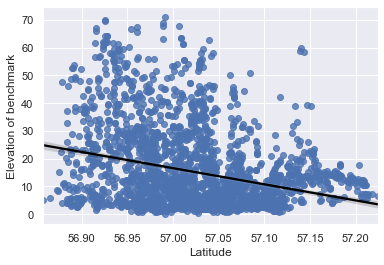

In [87]:
p2 = sns.regplot(x=y, y=z, line_kws = {'color': 'black'})
p2.set(xlabel='Latitude', ylabel='Elevation of benchmark');

Next i have created a plot to show the spatial distribution of benchmarks. Because of the large amount of benchmarks this can be hard to comprehend from just a map, so i have used the "jointplot" function which shows the marginal distribution along each axis with a histogram.

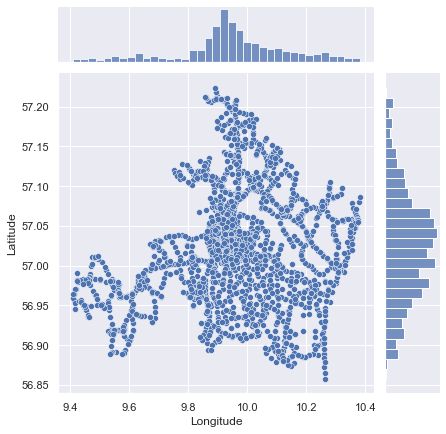

In [86]:
p3 = sns.jointplot(x=x, y=y)
p3.ax_joint.set_xlabel('Longitude');
p3.ax_joint.set_ylabel('Latitude');

There are generally more benchmarks towards the center of the municipality, which makes sense as this is where Aalborg and the surrounding smaller towns are placed - and urban enviroments are where benchmarks are mostly needed.